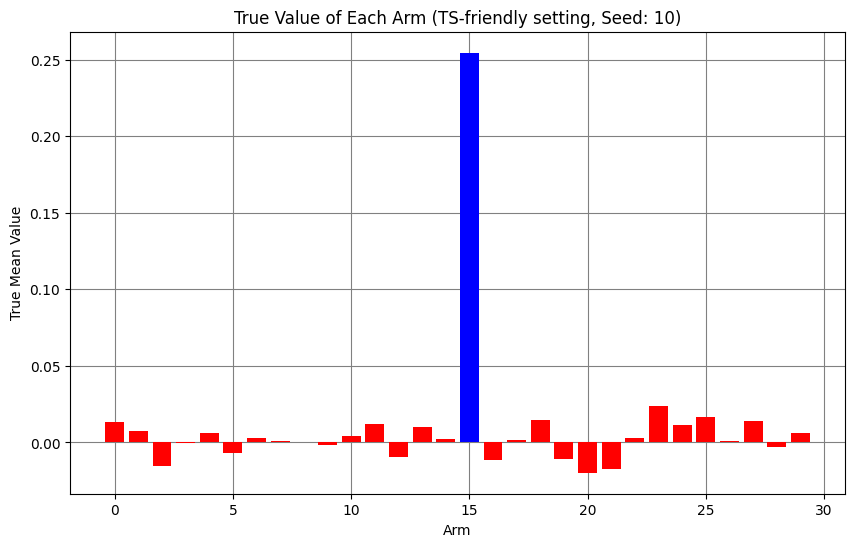

In [40]:
import numpy as np
import matplotlib.pyplot as plt

class BanditEnv:
    def __init__(self, k=30, random_seed=None):
        self.k = k
        if random_seed is not None:
            np.random.seed(random_seed)
        # 多數 arm 極為相似（難分辨）
        self.true_means = np.random.normal(loc=0, scale=0.01, size=k)
        # 最佳 arm 比其他大一些
        self.optimal_arm = np.random.randint(k)
        self.true_means[self.optimal_arm] += 0.25  # 明確但細微的差距

    def pull(self, arm):
        return np.random.normal(self.true_means[arm], 1)

# 設定隨機種子
random_seed = 10
env = BanditEnv(k=30, random_seed=random_seed)

# 繪圖：每個 arm 的真實價值
plt.figure(figsize=(10, 6))
colors = ['red' if i != env.optimal_arm else 'blue' for i in range(env.k)]
plt.bar(range(env.k), env.true_means, color=colors, zorder=3)  # Set a higher zorder for bars
plt.xlabel('Arm')
plt.ylabel('True Mean Value')
plt.title(f'True Value of Each Arm (TS-friendly setting, Seed: {random_seed})')
plt.grid(True, color='grey', zorder=0)  # Set a lower zorder for the grid
plt.show()

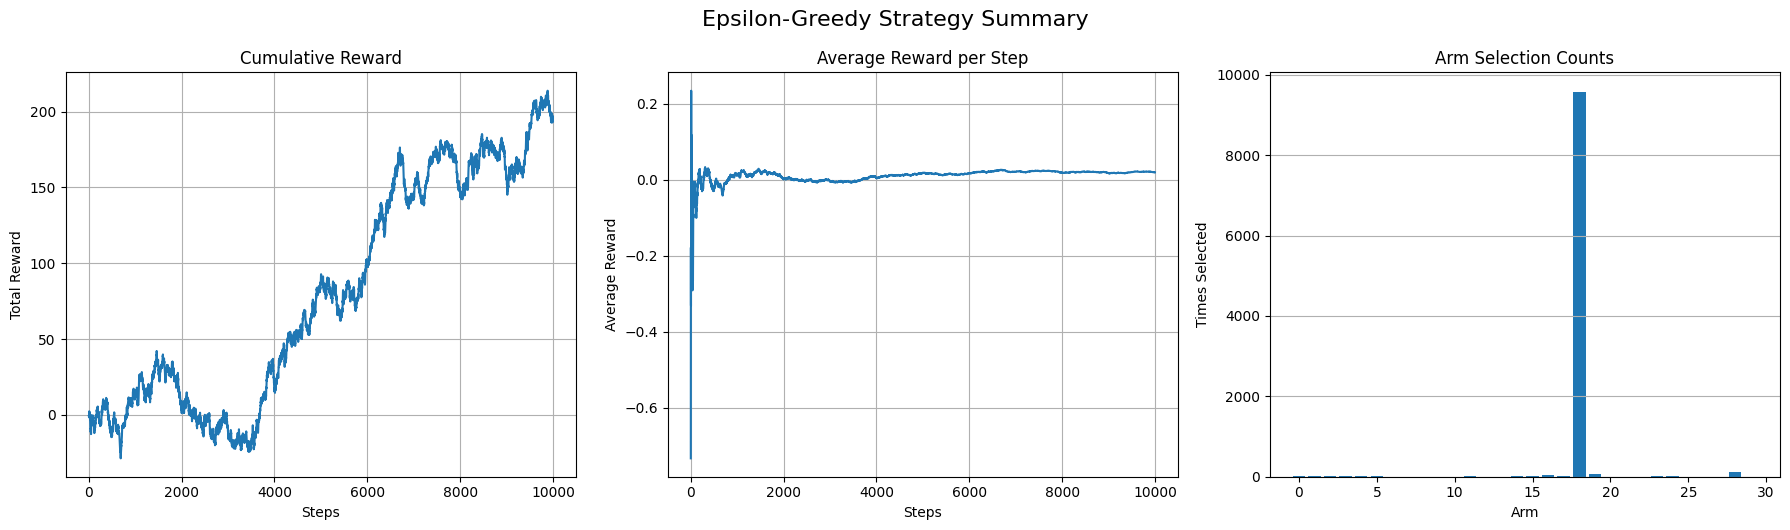

In [16]:
# epsilon-greedy 策略
def epsilon_greedy(env, epsilon=0.01, steps=10000):
    k = env.k
    Q = np.zeros(k)  # 初始化每個 arm 的估計值
    N = np.zeros(k)  # 初始化每個 arm 被選擇的次數
    rewards = []
    cumulative = 0

    for t in range(steps):
        if np.random.rand() < epsilon:
            action = np.random.choice(k)  # 探索
        else:
            action = np.argmax(Q)  # 利用

        reward = env.pull(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]  # 更新估計
        cumulative += reward
        rewards.append(cumulative)

    return rewards, N

# 執行改進的 epsilon-greedy 策略
eps_rewards, eps_N = epsilon_greedy(env, epsilon=0.01)

# 計算平均每步報酬
avg_rewards = [r / (i + 1) for i, r in enumerate(eps_rewards)]

# 繪製圖表
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 累積報酬
axes[0].plot(eps_rewards)
axes[0].set_title('Cumulative Reward')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Total Reward')
axes[0].grid(True)

# 2. 平均每步報酬
axes[1].plot(avg_rewards)
axes[1].set_title('Average Reward per Step')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Average Reward')
axes[1].grid(True)

# 3. 每個 arm 的選擇次數
axes[2].bar(np.arange(env.k), eps_N)
axes[2].set_title('Arm Selection Counts')
axes[2].set_xlabel('Arm')
axes[2].set_ylabel('Times Selected')
axes[2].grid(True, axis='y')

plt.tight_layout()
plt.suptitle('Epsilon-Greedy Strategy Summary', fontsize=16, y=1.05)
plt.show()




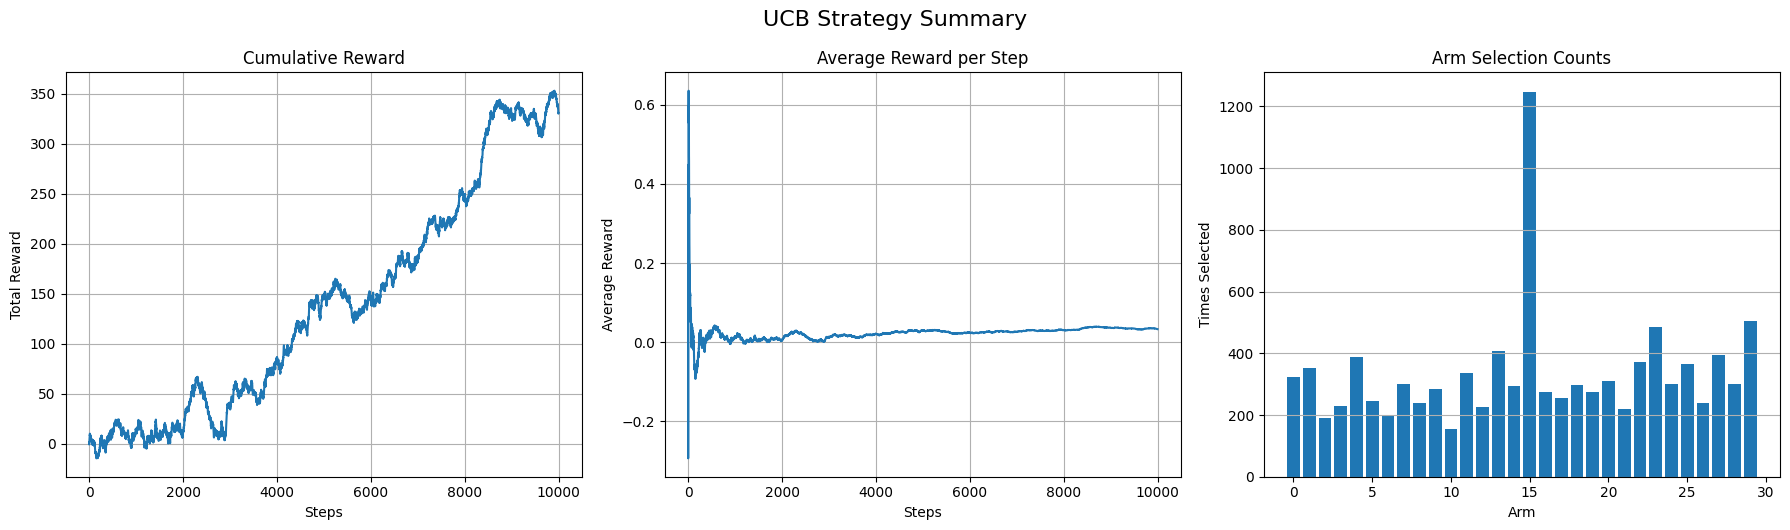

In [17]:
# UCB 策略
def ucb(env, c=3, steps=10000):
    k = env.k
    Q = np.zeros(k)  # 每個 arm 的估算期望報酬
    N = np.zeros(k)  # 每個 arm 被選擇的次數
    rewards = []
    cumulative = 0

    for t in range(1, steps + 1):
        ucb_values = Q + c * np.sqrt(np.log(t) / (N + 1e-6))  # 計算 UCB 值，避免除以零
        # 隨機選擇具有最大 UCB 值的 arm
        max_ucb_value = np.max(ucb_values)
        best_arms = np.where(ucb_values == max_ucb_value)[0]
        action = np.random.choice(best_arms)  # 隨機選擇其中一個最佳 arm

        reward = env.pull(action)

        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]  # 更新 Q 值
        cumulative += reward
        rewards.append(cumulative)

    return rewards, N

# 執行 UCB 策略
ucb_rewards, ucb_N = ucb(env)

# 計算平均每步報酬
avg_rewards = [r / (i + 1) for i, r in enumerate(ucb_rewards)]

# 繪製圖表
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 累積報酬
axes[0].plot(ucb_rewards)
axes[0].set_title('Cumulative Reward')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Total Reward')
axes[0].grid(True)

# 2. 平均每步報酬
axes[1].plot(avg_rewards)
axes[1].set_title('Average Reward per Step')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Average Reward')
axes[1].grid(True)

# 3. 每個 arm 的選擇次數
axes[2].bar(np.arange(env.k), ucb_N)
axes[2].set_title('Arm Selection Counts')
axes[2].set_xlabel('Arm')
axes[2].set_ylabel('Times Selected')
axes[2].grid(True, axis='y')

plt.tight_layout()
plt.suptitle('UCB Strategy Summary', fontsize=16, y=1.05)
plt.show()



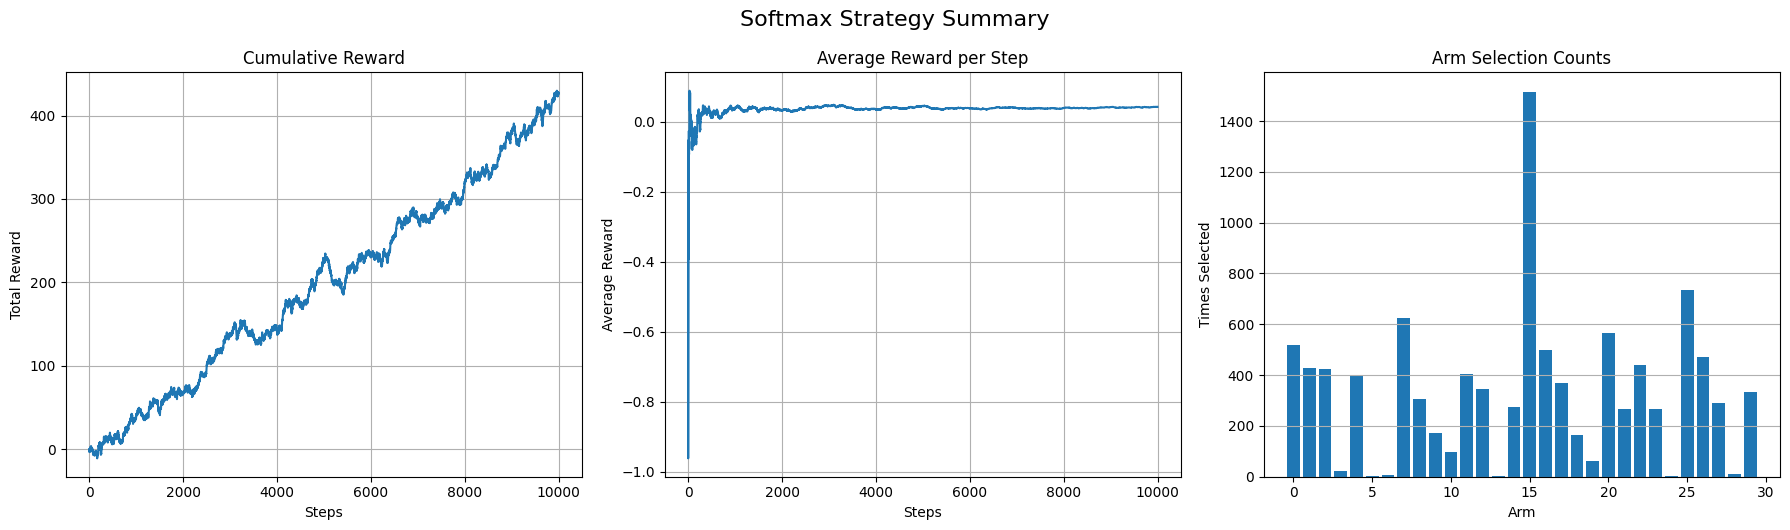

In [18]:
# Softmax 策略
def softmax(env, tau=0.2, steps=10000):
    k = env.k
    Q = np.zeros(k)  # 每個 arm 的估算期望報酬
    N = np.zeros(k)  # 每個 arm 被選擇的次數
    rewards = []
    cumulative = 0

    for t in range(steps):
        exp_Q = np.exp(Q / tau)  # 計算 Q 值的 Softmax 機率
        probs = exp_Q / np.sum(exp_Q)  # 機率正規化
        action = np.random.choice(k, p=probs)  # 根據機率選擇 arm

        reward = env.pull(action)
        N[action] += 1
        Q[action] += (reward - Q[action]) / N[action]
        cumulative += reward
        rewards.append(cumulative)

    return rewards, N

# 執行 Softmax 策略
softmax_rewards, softmax_N = softmax(env)

# 計算平均每步報酬
avg_rewards = [r / (i + 1) for i, r in enumerate(softmax_rewards)]

# 繪製圖表
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 累積報酬
axes[0].plot(softmax_rewards)
axes[0].set_title('Cumulative Reward')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Total Reward')
axes[0].grid(True)

# 2. 平均每步報酬
axes[1].plot(avg_rewards)
axes[1].set_title('Average Reward per Step')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Average Reward')
axes[1].grid(True)

# 3. 每個 arm 的選擇次數
axes[2].bar(np.arange(env.k), softmax_N)
axes[2].set_title('Arm Selection Counts')
axes[2].set_xlabel('Arm')
axes[2].set_ylabel('Times Selected')
axes[2].grid(True, axis='y')

plt.tight_layout()
plt.suptitle('Softmax Strategy Summary', fontsize=16, y=1.05)
plt.show()



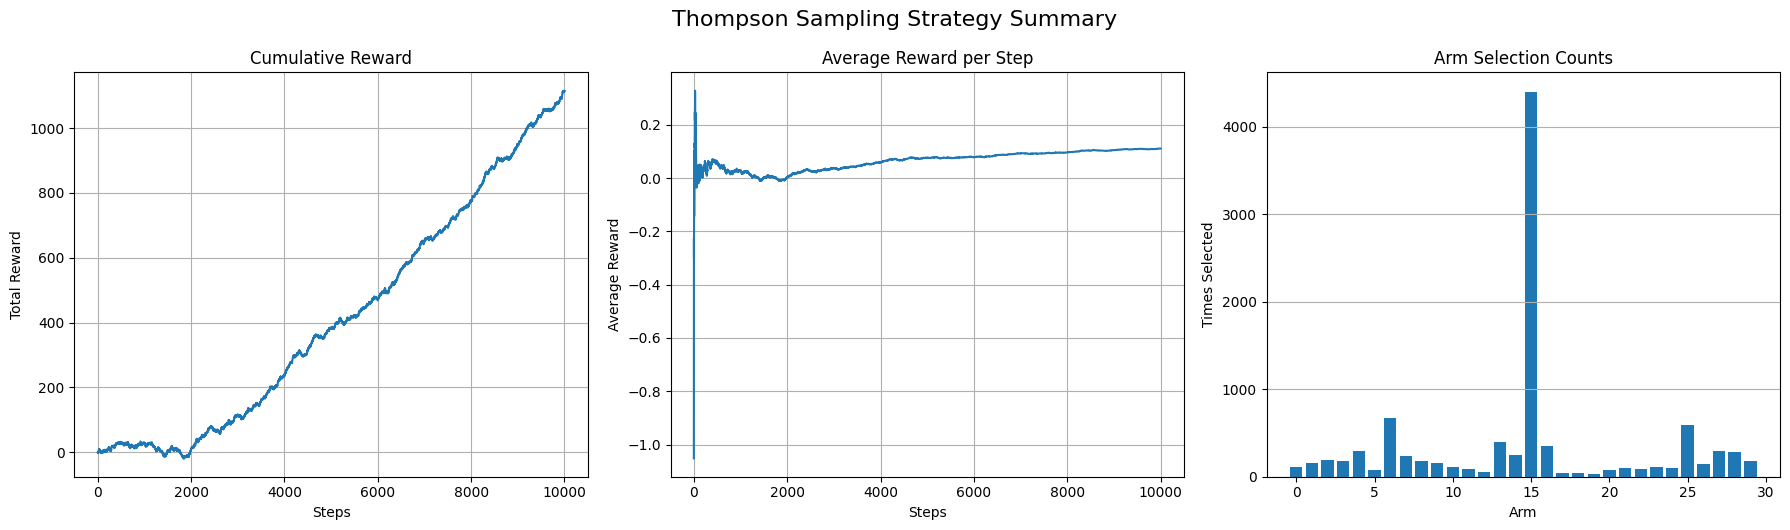

In [19]:
def thompson_sampling(env, steps=10000):
    k = env.k
    alpha = np.ones(k)
    beta = np.ones(k)
    rewards = []
    cumulative = 0
    N = np.zeros(k)  # 記錄每個 arm 被選擇的次數

    for t in range(steps):
        theta = np.random.beta(alpha, beta)  # 根據 beta 分佈進行抽樣
        action = np.argmax(theta)  # 選擇期望報酬最大的 arm
        reward = env.pull(action)

        # 將常態分佈的報酬轉換為二元回報
        reward_bin = 1 if reward > 0 else 0

        # 更新 Beta 分佈參數
        alpha[action] += reward_bin
        beta[action] += 1 - reward_bin
        cumulative += reward
        rewards.append(cumulative)
        N[action] += 1

    return rewards, N

# 執行 Thompson Sampling 策略
ts_rewards, ts_N = thompson_sampling(env)

# 計算平均每步報酬
avg_rewards = [r / (i + 1) for i, r in enumerate(ts_rewards)]

# 繪製圖表
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. 累積報酬
axes[0].plot(ts_rewards)
axes[0].set_title('Cumulative Reward')
axes[0].set_xlabel('Steps')
axes[0].set_ylabel('Total Reward')
axes[0].grid(True)

# 2. 平均每步報酬
axes[1].plot(avg_rewards)
axes[1].set_title('Average Reward per Step')
axes[1].set_xlabel('Steps')
axes[1].set_ylabel('Average Reward')
axes[1].grid(True)

# 3. 每個 arm 的選擇次數
axes[2].bar(np.arange(env.k), ts_N)
axes[2].set_title('Arm Selection Counts')
axes[2].set_xlabel('Arm')
axes[2].set_ylabel('Times Selected')
axes[2].grid(True, axis='y')

plt.tight_layout()
plt.suptitle('Thompson Sampling Strategy Summary', fontsize=16, y=1.05)
plt.show()



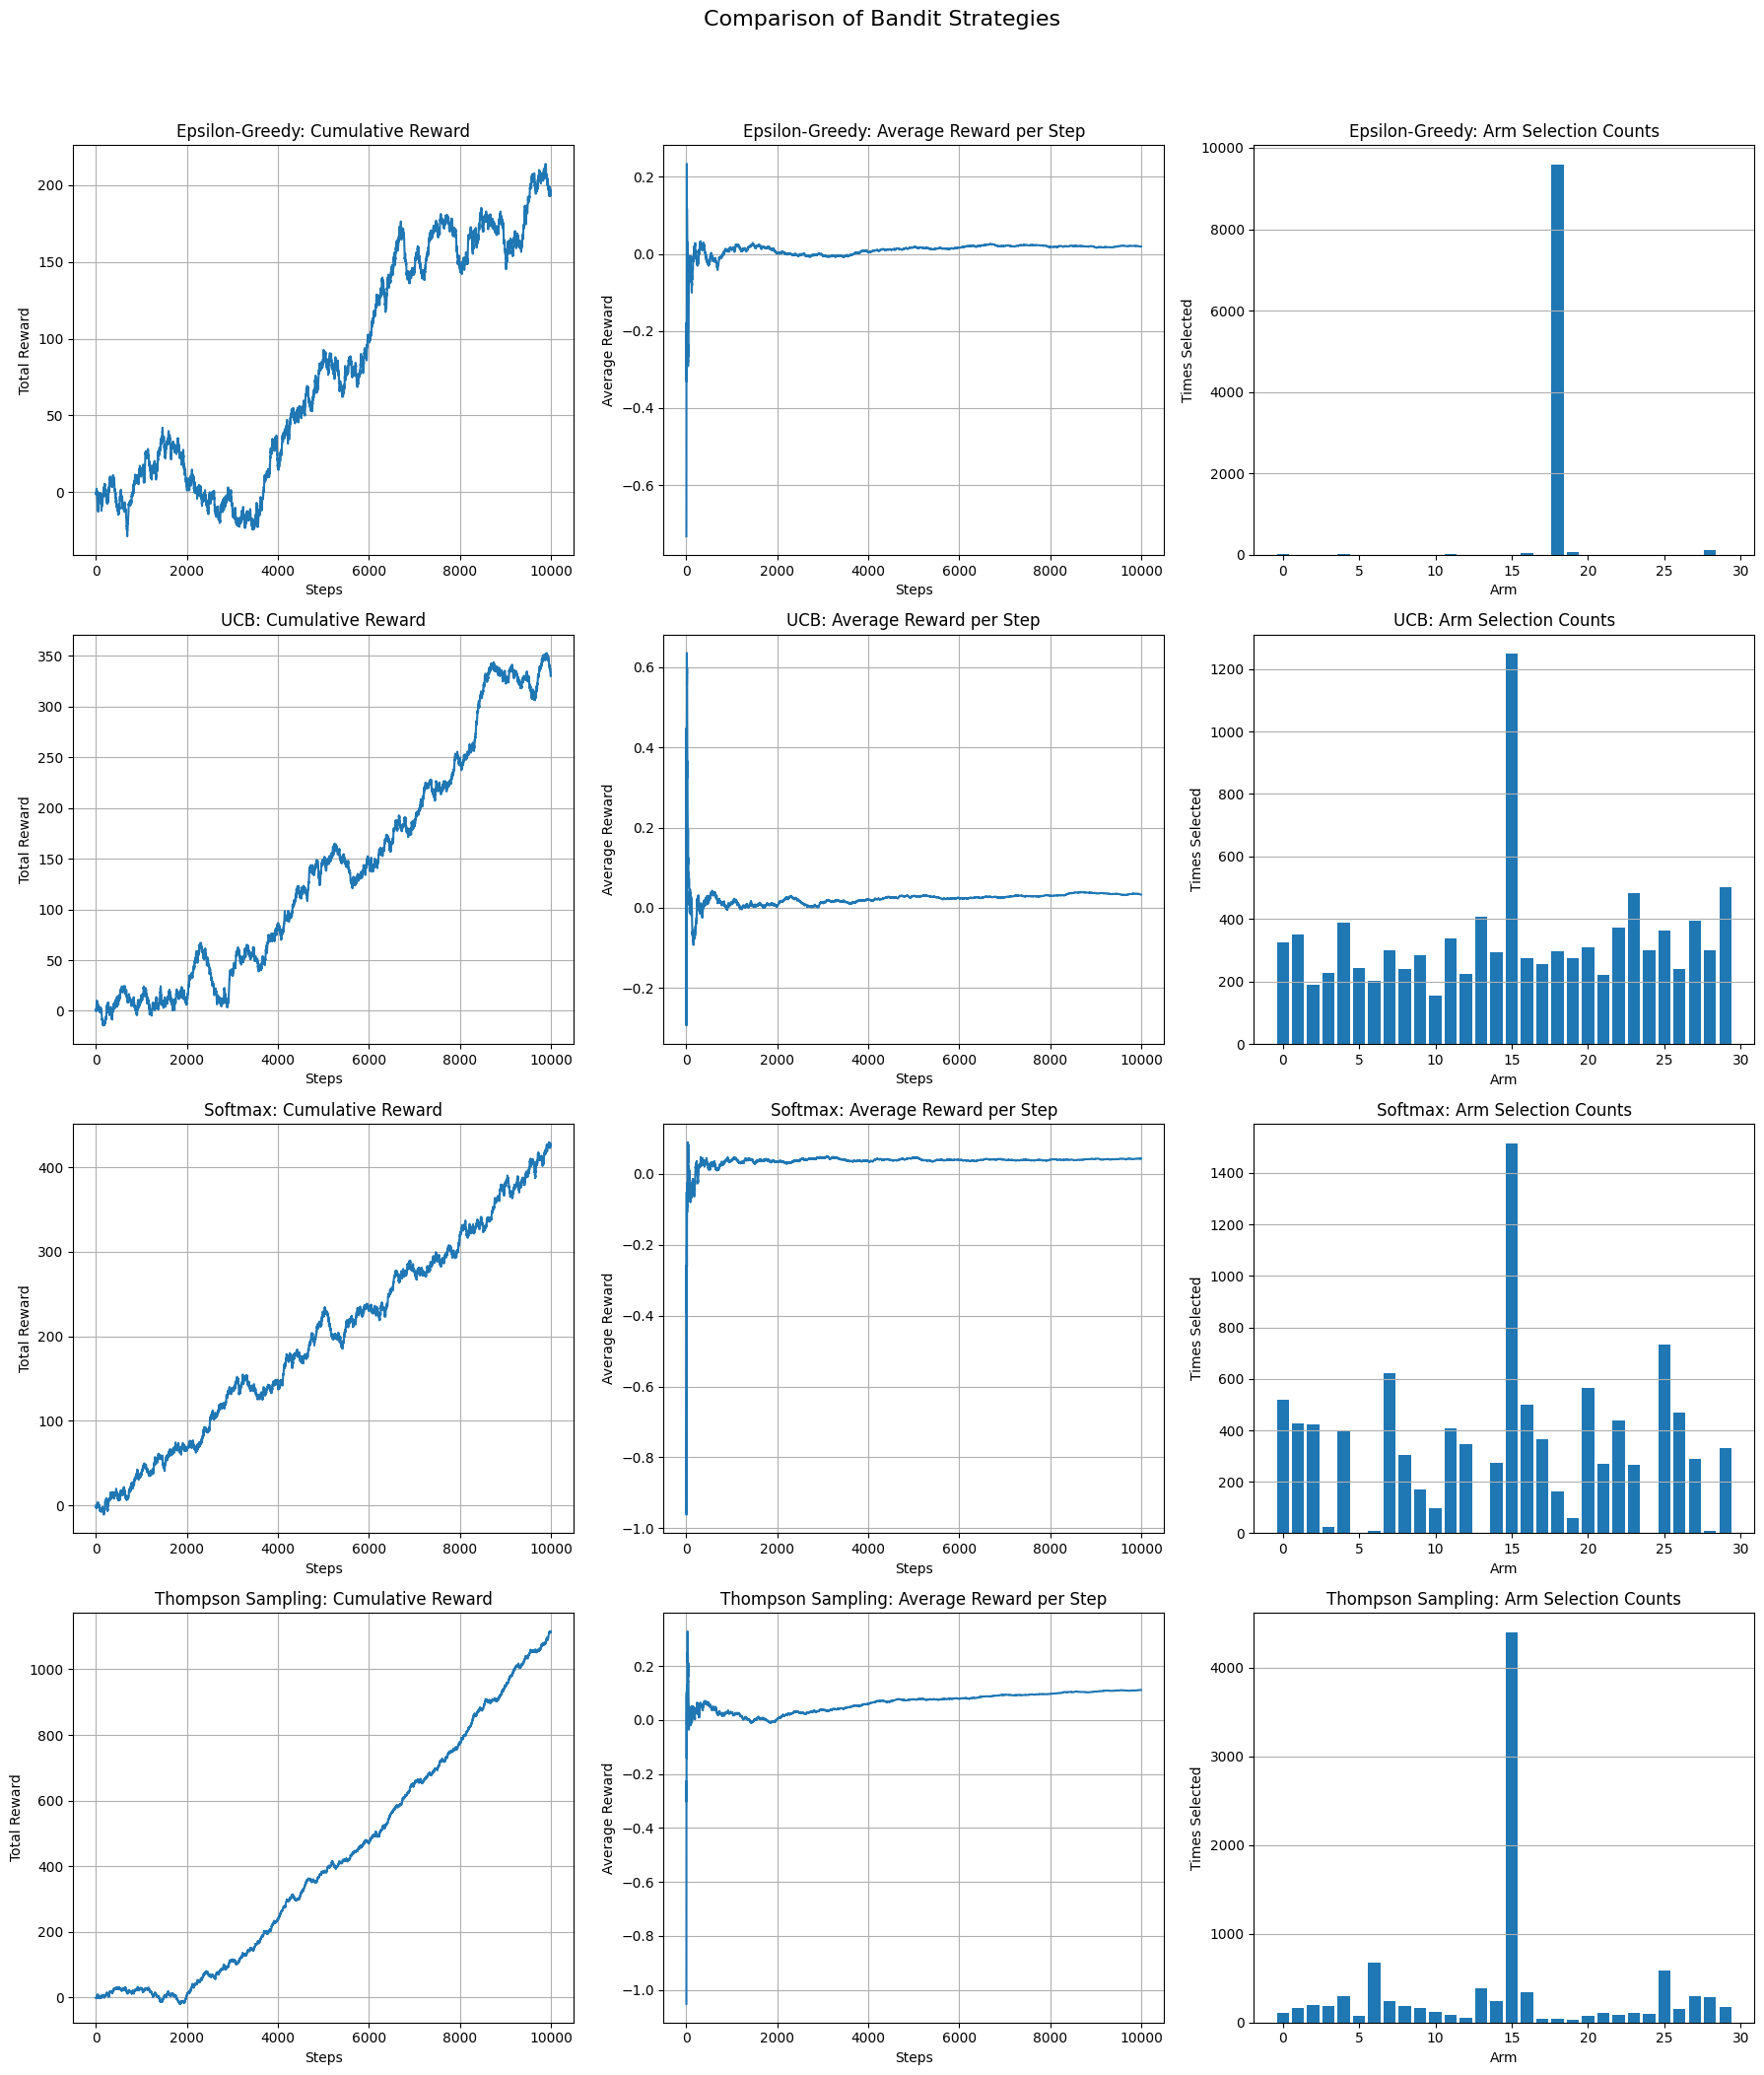

In [20]:
env = BanditEnv(k=30, random_seed=random_seed)

# 計算每個策略的平均每步報酬
eps_avg_rewards = [r / (i + 1) for i, r in enumerate(eps_rewards)]
ucb_avg_rewards = [r / (i + 1) for i, r in enumerate(ucb_rewards)]
softmax_avg_rewards = [r / (i + 1) for i, r in enumerate(softmax_rewards)]
ts_avg_rewards = [r / (i + 1) for i, r in enumerate(ts_rewards)]

# 繪製四個策略的結果進行比較
fig, axes = plt.subplots(4, 3, figsize=(18, 20))

# Epsilon-Greedy 策略
axes[0, 0].plot(eps_rewards)
axes[0, 0].set_title('Epsilon-Greedy: Cumulative Reward')
axes[0, 0].set_xlabel('Steps')
axes[0, 0].set_ylabel('Total Reward')
axes[0, 0].grid(True)

axes[0, 1].plot(eps_avg_rewards)
axes[0, 1].set_title('Epsilon-Greedy: Average Reward per Step')
axes[0, 1].set_xlabel('Steps')
axes[0, 1].set_ylabel('Average Reward')
axes[0, 1].grid(True)

axes[0, 2].bar(np.arange(env.k), eps_N)
axes[0, 2].set_title('Epsilon-Greedy: Arm Selection Counts')
axes[0, 2].set_xlabel('Arm')
axes[0, 2].set_ylabel('Times Selected')
axes[0, 2].grid(True, axis='y')

# UCB 策略
axes[1, 0].plot(ucb_rewards)
axes[1, 0].set_title('UCB: Cumulative Reward')
axes[1, 0].set_xlabel('Steps')
axes[1, 0].set_ylabel('Total Reward')
axes[1, 0].grid(True)

axes[1, 1].plot(ucb_avg_rewards)
axes[1, 1].set_title('UCB: Average Reward per Step')
axes[1, 1].set_xlabel('Steps')
axes[1, 1].set_ylabel('Average Reward')
axes[1, 1].grid(True)

axes[1, 2].bar(np.arange(env.k), ucb_N)
axes[1, 2].set_title('UCB: Arm Selection Counts')
axes[1, 2].set_xlabel('Arm')
axes[1, 2].set_ylabel('Times Selected')
axes[1, 2].grid(True, axis='y')

# Softmax 策略
axes[2, 0].plot(softmax_rewards)
axes[2, 0].set_title('Softmax: Cumulative Reward')
axes[2, 0].set_xlabel('Steps')
axes[2, 0].set_ylabel('Total Reward')
axes[2, 0].grid(True)

axes[2, 1].plot(softmax_avg_rewards)
axes[2, 1].set_title('Softmax: Average Reward per Step')
axes[2, 1].set_xlabel('Steps')
axes[2, 1].set_ylabel('Average Reward')
axes[2, 1].grid(True)

axes[2, 2].bar(np.arange(env.k), softmax_N)
axes[2, 2].set_title('Softmax: Arm Selection Counts')
axes[2, 2].set_xlabel('Arm')
axes[2, 2].set_ylabel('Times Selected')
axes[2, 2].grid(True, axis='y')

# Thompson Sampling 策略
axes[3, 0].plot(ts_rewards)
axes[3, 0].set_title('Thompson Sampling: Cumulative Reward')
axes[3, 0].set_xlabel('Steps')
axes[3, 0].set_ylabel('Total Reward')
axes[3, 0].grid(True)

axes[3, 1].plot(ts_avg_rewards)
axes[3, 1].set_title('Thompson Sampling: Average Reward per Step')
axes[3, 1].set_xlabel('Steps')
axes[3, 1].set_ylabel('Average Reward')
axes[3, 1].grid(True)

axes[3, 2].bar(np.arange(env.k), ts_N)
axes[3, 2].set_title('Thompson Sampling: Arm Selection Counts')
axes[3, 2].set_xlabel('Arm')
axes[3, 2].set_ylabel('Times Selected')
axes[3, 2].grid(True, axis='y')

# 調整佈局
plt.tight_layout()
plt.suptitle('Comparison of Bandit Strategies', fontsize=16, y=1.05)
plt.show()



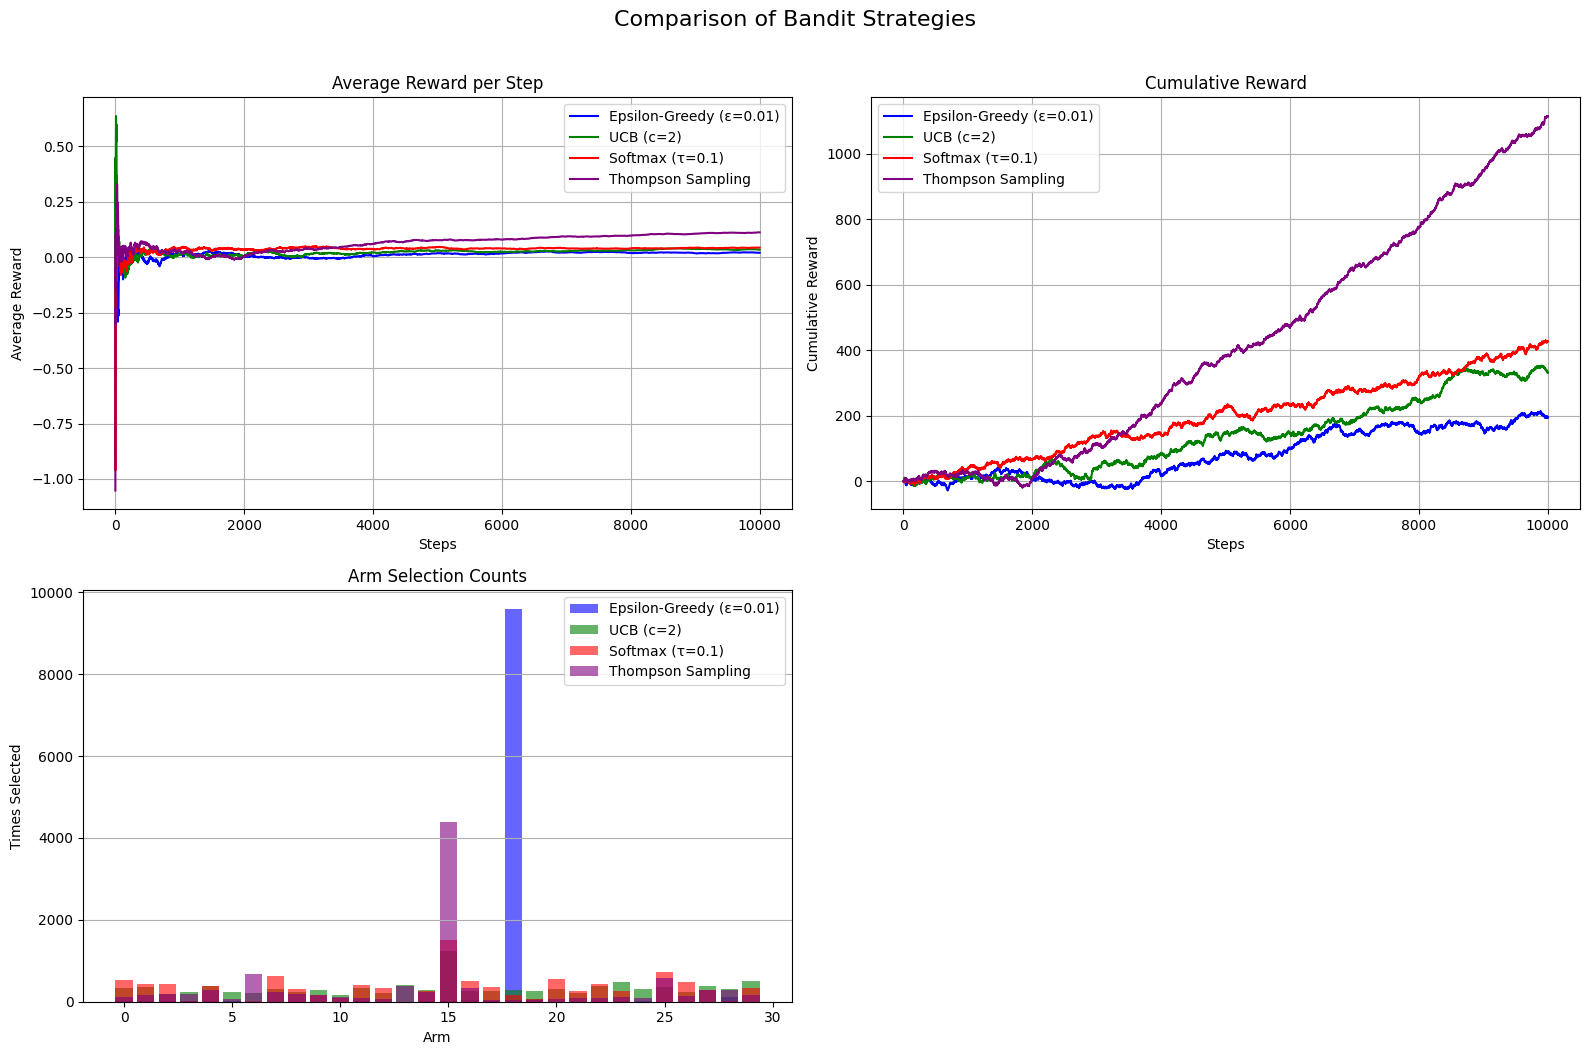

In [29]:
# 繪製所有策略的比較圖表
plt.figure(figsize=(16, 10))

# 子圖：平均每步報酬
plt.subplot(2, 2, 1)
plt.plot(eps_avg_rewards, label='Epsilon-Greedy (ε=0.01)', color='b')
plt.plot(ucb_avg_rewards, label='UCB (c=2)', color='g')
plt.plot(softmax_avg_rewards, label='Softmax (τ=0.1)', color='r')
plt.plot(ts_avg_rewards, label='Thompson Sampling', color='purple')
plt.title('Average Reward per Step')
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend()
plt.grid(True)

# 子圖：累積報酬
plt.subplot(2, 2, 2)
plt.plot(eps_rewards, label='Epsilon-Greedy (ε=0.01)', color='b')
plt.plot(ucb_rewards, label='UCB (c=2)', color='g')
plt.plot(softmax_rewards, label='Softmax (τ=0.1)', color='r')
plt.plot(ts_rewards, label='Thompson Sampling', color='purple')
plt.title('Cumulative Reward')
plt.xlabel('Steps')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.grid(True)

# 子圖：每個 arm 的選擇次數
plt.subplot(2, 2, 3)
plt.bar(np.arange(env.k), eps_N, alpha=0.6, label='Epsilon-Greedy (ε=0.01)', color='b')
plt.bar(np.arange(env.k), ucb_N, alpha=0.6, label='UCB (c=2)', color='g')
plt.bar(np.arange(env.k), softmax_N, alpha=0.6, label='Softmax (τ=0.1)', color='r')
plt.bar(np.arange(env.k), ts_N, alpha=0.6, label='Thompson Sampling', color='purple')
plt.title('Arm Selection Counts')
plt.xlabel('Arm')
plt.ylabel('Times Selected')
plt.legend()
plt.grid(True, axis='y')


# 顯示圖表
plt.tight_layout()
plt.suptitle('Comparison of Bandit Strategies', fontsize=16, y=1.05)
plt.show()
